In [1]:
import os

os.environ.update({"TF_CPP_MIN_LOG_LEVEL": "3", "CUDA_VISIBLE_DEVICES": ""})

import numpy as np
import tensorflow as tf
from matplotlib.cm import get_cmap
from PIL import Image
from scipy.ndimage import gaussian_filter

import chiron


In [2]:
results_dir = "../results/combined-4-class"
epoch = 10
tfrecord_file = "../tfrecord/cheng-et-al/fold-1/val.tfrecord"
batch_size = 32


In [3]:
model = chiron.utils.load_model(os.path.join(results_dir, "model.json"))
model.load_weights(
    os.path.join(
        results_dir,
        "weights",
        chiron.utils.get_weights_path().format(epoch=epoch),
    )
)
config = chiron.utils.load_yaml(os.path.join(results_dir, "config.yaml"))
image_size = tf.TensorShape(config["image_size"])
model.build([None] + image_size + [3])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 5,924,436
Trainable params: 5,863,828
Non-trainable params: 60,608
_________________________________________________________________


In [4]:
raw_dataset = chiron.tfrecord.load_tfrecord(tfrecord_file)


def generate_images():
    dataset = (
        raw_dataset.map(chiron.preprocessing.MinMaxScaler())
        .map(chiron.preprocessing.ConvertImageDtype(tf.uint8))
        .map(chiron.preprocessing.GrayscaleToRgb())
    )
    for image, _ in dataset:
        yield image.numpy()


def generate_s_maps():
    dataset = (
        raw_dataset.map(chiron.preprocessing.Resizer(image_size))
        .batch(batch_size)
        .map(chiron.preprocessing.PerImageStandardizer())
        .map(chiron.preprocessing.GrayscaleToRgb())
    )
    for images, _ in dataset:
        with tf.GradientTape() as tape:
            tape.watch(images)
            scores = tf.nn.softmax(model(images, training=False))
            losses = tf.reduce_max(scores, axis=1)
        gradients = tape.gradient(losses, images)
        s_maps = tf.reduce_max(gradients, axis=3)
        yield from s_maps.numpy()


def generate():
    yield from zip(generate_images(), generate_s_maps())


gen = generate()


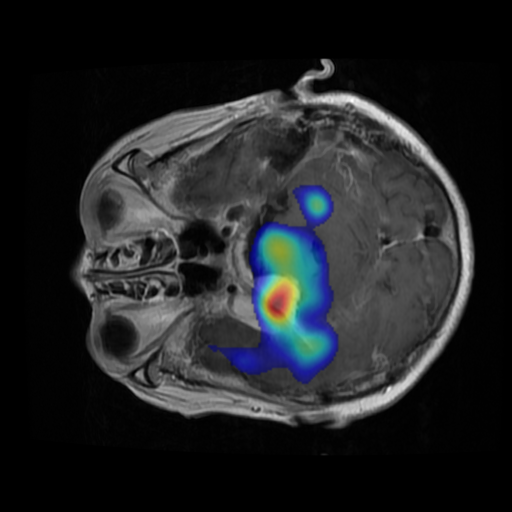

In [5]:
image, s_map = next(gen)

image = Image.fromarray(image)

s_map = gaussian_filter(s_map, 5)
threshold = np.percentile(s_map, 95)
s_map = np.ma.masked_less(s_map, threshold, copy=False)
s_map -= s_map.min()
s_map *= 1 / s_map.max()
s_map = get_cmap("jet")(s_map, alpha=0.5)
s_map *= 255
s_map = s_map.astype(np.uint8)
s_map = Image.fromarray(s_map)

Image.alpha_composite(image.convert("RGBA"), s_map.resize(image.size))
